In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import random

np.random.seed(0) 
random.seed(0)


In [2]:
import yaml
import shutil
import json
import numpy as np
from pathlib import Path

try:
    import torch
    from ultralytics import YOLO
    torch_available = True
except ImportError:
    torch_available = False

try:
    from PIL import Image
    pil_available = True
except ImportError:
    pil_available = False

class SurgicalHandsIntegrator:
    def __init__(self, hands_dataset_path):
        self.hands_dataset_path = Path(hands_dataset_path)
        self.images_dir = self.hands_dataset_path / "images"
        self.annotations_file = self.hands_dataset_path / "annotations.json"
        # Corrigido: usar classes válidas do YOLO (0-79)
        self.hand_class_mapping = {
            'hand': 0,
            'left_hand': 0,
            'right_hand': 1,
            0: 0,
            1: 1,
            'Hand': 0,
            'hands': 0
        }

    def load_hand_annotations(self):
        try:
            with open(self.annotations_file, 'r', encoding='utf-8') as f:
                annotations = json.load(f)
            print(f"Anotações carregadas: {len(annotations)} items")
            if isinstance(annotations, dict):
                if 'images' in annotations and 'annotations' in annotations:
                    return annotations
                else:
                    return annotations
            else:
                return None
        except Exception as e:
            print(f"Erro ao carregar anotações: {e}")
            return None

    def process_coco_format(self, annotations, output_dir):
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        images_data = annotations['images']
        annotations_data = annotations['annotations']
        categories = annotations.get('categories', [])
        
        # Mapeamento corrigido para classes válidas
        category_mapping = {}
        for cat in categories:
            cat_id = cat['id']
            cat_name = cat['name'].lower()
            if 'hand' in cat_name or 'mão' in cat_name:
                if 'left' in cat_name or 'esquerda' in cat_name:
                    category_mapping[cat_id] = 0  # left_hand
                elif 'right' in cat_name or 'direita' in cat_name:
                    category_mapping[cat_id] = 1  # right_hand
                else:
                    category_mapping[cat_id] = 0  # hand genérica
        
        annotations_by_image = {}
        for ann in annotations_data:
            img_id = ann['image_id']
            if img_id not in annotations_by_image:
                annotations_by_image[img_id] = []
            annotations_by_image[img_id].append(ann)
        
        processed_count = 0
        
        for img_data in images_data:
            img_id = img_data['id']
            img_filename = img_data['file_name']
            img_width = img_data['width']
            img_height = img_data['height']
            
            if img_id not in annotations_by_image:
                continue
            
            img_annotations = annotations_by_image[img_id]
            hand_annotations = []
            for ann in img_annotations:
                cat_id = ann['category_id']
                if cat_id in category_mapping:
                    hand_annotations.append(ann)
            
            if not hand_annotations:
                continue
            
            img_path = self.find_image_file(img_filename)
            if not img_path:
                print(f"Imagem não encontrada: {img_filename}")
                continue
            
            yolo_annotations = []
            for ann in hand_annotations:
                bbox = ann['bbox']
                x, y, w, h = bbox
                
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                width_norm = w / img_width
                height_norm = h / img_height
                
                class_id = category_mapping[ann['category_id']]
                
                if (0 <= x_center <= 1 and 0 <= y_center <= 1 and 
                    0 < width_norm <= 1 and 0 < height_norm <= 1):
                    yolo_annotations.append([class_id, x_center, y_center, width_norm, height_norm])
                    print(f"Bbox convertida: classe {class_id}, coords: {[x_center, y_center, width_norm, height_norm]}")
            
            if yolo_annotations:
                new_img_name = f"hand_{processed_count:06d}.jpg"
                
                if pil_available and img_path.suffix.lower() != '.jpg':
                    pil_image = Image.open(img_path).convert('RGB')
                    pil_image.save(output_dir / "images" / new_img_name, 'JPEG')
                else:
                    shutil.copy(img_path, output_dir / "images" / new_img_name)
                
                label_file = output_dir / "labels" / f"hand_{processed_count:06d}.txt"
                with open(label_file, 'w') as f:
                    for detection in yolo_annotations:
                        line = ' '.join(map(str, detection))
                        f.write(line + '\n')
                
                processed_count += 1
        
        print(f"Processadas {processed_count} imagens com mãos")
        return processed_count

    def find_image_file(self, filename):
        possible_paths = [
            self.images_dir / filename,
            self.hands_dataset_path / filename,
            self.hands_dataset_path / "images" / filename
        ]
        
        for subfolder in self.images_dir.glob("*"):
            if subfolder.is_dir():
                possible_paths.append(subfolder / filename)
        
        for path in possible_paths:
            if path.exists():
                return path
        
        return None

    def process_hands_dataset(self, output_dir):
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        all_annotations = self.load_hand_annotations()
        if not all_annotations:
            print("Não foi possível carregar anotações")
            return 0
        
        if 'images' in all_annotations and 'annotations' in all_annotations:
            return self.process_coco_format(all_annotations, output_dir)
        else:
            return self.process_sequence_format(all_annotations, output_dir)

    def process_sequence_format(self, all_annotations, output_dir):
        all_images = self.find_all_images()
        if not all_images:
            return 0
        
        processed_count = 0
        
        for img_file in all_images:
            try:
                hand_detections = self.get_sequence_annotations(img_file, all_annotations)
                
                if hand_detections:
                    new_img_name = f"hand_{processed_count:06d}.jpg"
                    
                    if pil_available and img_file.suffix.lower() != '.jpg':
                        pil_image = Image.open(img_file).convert('RGB')
                        pil_image.save(output_dir / "images" / new_img_name, 'JPEG')
                    else:
                        shutil.copy(img_file, output_dir / "images" / new_img_name)
                    
                    label_file = output_dir / "labels" / f"hand_{processed_count:06d}.txt"
                    with open(label_file, 'w') as f:
                        for detection in hand_detections:
                            line = ' '.join(map(str, detection))
                            f.write(line + '\n')
                    
                    processed_count += 1
            except Exception as e:
                print(f"Erro processando {img_file}: {e}")
                continue
        
        return processed_count

    def find_all_images(self):
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        all_images = []
        
        if self.images_dir.exists():
            for subfolder in self.images_dir.iterdir():
                if subfolder.is_dir():
                    folder_images = []
                    for ext in image_extensions:
                        found = list(subfolder.glob(ext))
                        found.extend(list(subfolder.glob(ext.upper())))
                        folder_images.extend(found)
                    all_images.extend(folder_images)
        
        return all_images

    def get_sequence_annotations(self, img_file, all_annotations):
        sequence_name = img_file.parent.name
        img_filename = img_file.name
        
        sequence_data = None
        matched_sequence = None
        
        if sequence_name in all_annotations:
            sequence_data = all_annotations[sequence_name]
            matched_sequence = sequence_name
        else:
            for seq_key in all_annotations.keys():
                if sequence_name in seq_key or seq_key in sequence_name:
                    sequence_data = all_annotations[seq_key]
                    matched_sequence = seq_key
                    break
        
        if sequence_data is None:
            return []
        
        if not isinstance(sequence_data, dict) or 'images' not in sequence_data or 'annotations' not in sequence_data:
            return []
        
        images_list = sequence_data['images']
        annotations_list = sequence_data['annotations']
        
        target_image_id = None
        target_image_info = None
        
        for img_info in images_list:
            file_name = img_info.get('file_name', '')
            
            if (img_filename == file_name or 
                img_file.stem == Path(file_name).stem or
                img_filename in file_name or 
                file_name in img_filename):
                target_image_id = img_info.get('id')
                target_image_info = img_info
                break
        
        if target_image_id is None:
            return []
        
        image_annotations = []
        for ann in annotations_list:
            if ann.get('image_id') == target_image_id:
                image_annotations.append(ann)
        
        if not image_annotations:
            return []
        
        try:
            if pil_available:
                pil_image = Image.open(img_file)
                w, h = pil_image.size
            else:
                w = target_image_info.get('width', 640)
                h = target_image_info.get('height', 480)
            
            yolo_annotations = self.convert_coco_to_yolo(image_annotations, w, h)
            return yolo_annotations
            
        except Exception:
            return []

    def convert_coco_to_yolo(self, annotations, image_width, image_height):
        yolo_annotations = []
        
        for ann in annotations:
            try:
                bbox = ann.get('bbox', [])
                if len(bbox) != 4:
                    continue
                
                x, y, w, h = bbox
                category_id = ann.get('category_id', 0)
                
                if category_id in self.hand_class_mapping:
                    class_id = self.hand_class_mapping[category_id]
                else:
                    # Heurística: mão esquerda se estiver no lado esquerdo da imagem
                    center_x = x + w / 2
                    class_id = 0 if center_x < image_width / 2 else 1
                
                x_center = (x + w / 2) / image_width
                y_center = (y + h / 2) / image_height
                width_norm = w / image_width
                height_norm = h / image_height
                
                if (0 <= x_center <= 1 and 0 <= y_center <= 1 and 
                    0 < width_norm <= 1 and 0 < height_norm <= 1):
                    yolo_annotations.append([class_id, x_center, y_center, width_norm, height_norm])
                
            except Exception as e:
                print(f"Erro convertendo anotação: {e}")
                continue
        
        return yolo_annotations

class AdvancedYOLOTrainer:
    def __init__(self, base_model):
        self.base_model = base_model
        if torch_available:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = "cpu"
        
    def prepare_combined_dataset(self, surgical_data_path, hands_dataset_path):
        combined_dir = Path("combined_surgical_dataset")
        (combined_dir / "images/train").mkdir(parents=True, exist_ok=True)
        (combined_dir / "labels/train").mkdir(parents=True, exist_ok=True)
        
        surgical_path = Path(surgical_data_path)
        instrument_count = 0
        
        # Copiar dados de instrumentos cirúrgicos
        if (surgical_path / "images/train").exists():
            for img_file in (surgical_path / "images/train").glob("*.jpg"):
                shutil.copy(img_file, combined_dir / "images/train" / img_file.name)
                
                label_file = surgical_path / "labels/train" / f"{img_file.stem}.txt"
                target_label = combined_dir / "labels/train" / f"{img_file.stem}.txt"
                
                if label_file.exists():
                    # Ajustar classes dos instrumentos para não conflitar com mãos
                    with open(label_file, 'r') as f:
                        lines = f.readlines()
                    
                    with open(target_label, 'w') as f:
                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                # Mapear classes de instrumentos para 2-5
                                old_class = int(parts[0])
                                new_class = old_class + 2  # Offset para não conflitar com mãos
                                parts[0] = str(new_class)
                                f.write(' '.join(parts) + '\n')
                else:
                    target_label.touch()
                
                instrument_count += 1
        
        # Processar dataset de mãos
        hands_integrator = SurgicalHandsIntegrator(hands_dataset_path)
        temp_hands_dir = Path("temp_hands_processed")
        hands_count = hands_integrator.process_hands_dataset(temp_hands_dir)
        
        # Mover dados de mãos para dataset combinado
        if temp_hands_dir.exists() and hands_count > 0:
            for img_file in (temp_hands_dir / "images").glob("*.jpg"):
                shutil.move(img_file, combined_dir / "images/train" / img_file.name)
            
            for label_file in (temp_hands_dir / "labels").glob("*.txt"):
                shutil.move(label_file, combined_dir / "labels/train" / label_file.name)
            
            shutil.rmtree(temp_hands_dir)
        
        total_images = instrument_count + hands_count
        
        # Configuração do dataset corrigida
        data_config = {
            'path': str(combined_dir.absolute()),
            'train': 'images/train',
            'val': 'images/train',
            'nc': 6,
            'names': ['left_hand', 'right_hand', 'needle', 'clamp', 'curved_scissor', 'straight_scissor']
        }
        
        with open(combined_dir / "data.yaml", "w") as f:
            yaml.dump(data_config, f)
        
        print(f"Dataset combinado criado: {total_images} imagens ({instrument_count} instrumentos + {hands_count} mãos)")
        return combined_dir

    def create_advanced_config(self):
        config = {
            'lr0': 0.001,  # Learning rate reduzido
            'lrf': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'box': 7.5,
            'cls': 0.5,
            'dfl': 1.5,
            'epochs': 50,  # Mais épocas
            'batch': 16,     # Batch menor para estabilidade
            'imgsz': 640,
            'patience': 50,
            'save_period': 10,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'degrees': 0.0,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 0.0,
            'perspective': 0.0,
            'flipud': 0.0,
            'fliplr': 0.5,
            'mosaic': 1.0,
            'mixup': 0.0,
            'copy_paste': 0.0,
            'dropout': 0.0,
            'val': True,
            'plots': True,
            'verbose': True
        }
        return config

    def train_with_advanced_features(self, data_path, use_optimization=True):
        if not torch_available:
            print("PyTorch não disponível - não é possível treinar")
            return None, 0.0
        
        config = self.create_advanced_config()
        print("Iniciando treino...")
        
        model = YOLO(self.base_model)
        results = model.train(
            data=data_path,
            **config
        )
        
        best_map = results.results_dict.get('metrics/mAP50(B)', 0.0)
        best_model_path = 'runs/detect/train/weights/best.pt'
        
        return best_model_path, best_map

def main():
    surgical_dataset_path = Path("yolo_dataset")
    hands_dataset_path = Path("surgical_hands_release")
    
    if not surgical_dataset_path.exists():
        print(f"Dataset de instrumentos não encontrado: {surgical_dataset_path}")
        return
    
    if not hands_dataset_path.exists():
        print(f"Dataset de mãos não encontrado: {hands_dataset_path}")
        return
    
    annotations_file = hands_dataset_path / "annotations.json"
    if not annotations_file.exists():
        print(f"Arquivo de anotações não encontrado: {annotations_file}")
        return
    
    # Preparar dataset de instrumentos se necessário
    yolo_dir = Path("yolo_dataset")
    if not (yolo_dir / "images/train").exists():
        (yolo_dir / "images/train").mkdir(parents=True, exist_ok=True)
        (yolo_dir / "labels/train").mkdir(parents=True, exist_ok=True)
        
        img_dir = surgical_dataset_path / "Images"
        label_dir = surgical_dataset_path / "Labels/label object names"
        
        if img_dir.exists() and label_dir.exists():
            copied_count = 0
            for label_file in label_dir.glob("*.txt"):
                img_id = label_file.stem
                img_file = img_dir / f"{img_id}.jpg"
                if img_file.exists():
                    shutil.copy(img_file, yolo_dir / "images/train" / f"{img_id}.jpg")
                    shutil.copy(label_file, yolo_dir / "labels/train" / f"{img_id}.txt")
                    copied_count += 1
            print(f"Preparados {copied_count} instrumentos cirúrgicos")
    
    trainer = AdvancedYOLOTrainer("yolo11n.pt")
    
    combined_dataset_path = trainer.prepare_combined_dataset(
        surgical_data_path=yolo_dir,
        hands_dataset_path=hands_dataset_path
    )
    
    if torch_available:
        data_config_path = combined_dataset_path / "data.yaml"
        best_model_path, best_map = trainer.train_with_advanced_features(
            data_path=data_config_path,
            use_optimization=False
        )
        
        print(f"\nTREINO CONCLUÍDO")
        print(f"mAP@0.5: {best_map:.4f}")
        print(f"Modelo salvo em: {best_model_path}")
        print("\nClasses detectáveis:")
        print("  0: left_hand | 1: right_hand | 2: needle | 3: clamp | 4: curved_scissor | 5: straight_scissor")
    else:
        print(f"Dataset combinado criado em: {combined_dataset_path}")

In [3]:
if __name__ == "__main__":
    main()

Anotações carregadas: 76 items
Dataset combinado criado: 5680 imagens (3009 instrumentos + 2671 mãos)
Iniciando treino...
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.139 🚀 Python-3.10.16 torch-2.7.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=combined_surgical_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train.cache... 5680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5680/5680 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1043.8±688.5 MB/s, size: 65.7 KB)


val: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train.cache... 5680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5680/5680 [00:00<?, ?it/s]


Plotting labels to runs/detect/train124/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train124
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.27G      1.529      2.735      1.724         43        640: 100%|██████████| 355/355 [00:38<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:19<00:00,  9.19it/s]


                   all       5680      10189      0.467      0.686      0.503      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.45G      1.389      1.938      1.579         49        640: 100%|██████████| 355/355 [00:37<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:18<00:00,  9.77it/s]


                   all       5680      10189      0.581       0.67      0.576      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.45G      1.375      1.711      1.551         52        640: 100%|██████████| 355/355 [00:38<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.02it/s]


                   all       5680      10189      0.525      0.723      0.604      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.45G      1.337       1.56       1.53         44        640: 100%|██████████| 355/355 [00:38<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.20it/s]


                   all       5680      10189      0.538      0.727      0.669      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.45G      1.282      1.435      1.482         77        640: 100%|██████████| 355/355 [00:37<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.06it/s]


                   all       5680      10189      0.594      0.775      0.701      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.45G      1.239      1.354       1.45         58        640: 100%|██████████| 355/355 [00:38<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.29it/s]

                   all       5680      10189      0.666      0.806      0.756      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.45G      1.198      1.293      1.421         65        640: 100%|██████████| 355/355 [00:38<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.20it/s]


                   all       5680      10189      0.721      0.808      0.777      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.45G      1.171      1.221      1.393         65        640: 100%|██████████| 355/355 [00:37<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.24it/s]


                   all       5680      10189      0.696      0.788       0.79      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.45G      1.149      1.176      1.382         52        640: 100%|██████████| 355/355 [00:37<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.15it/s]


                   all       5680      10189      0.668      0.855       0.79      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.45G      1.121      1.136       1.36         60        640: 100%|██████████| 355/355 [00:38<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.22it/s]


                   all       5680      10189      0.747      0.853      0.851       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.45G      1.099      1.111      1.346         60        640: 100%|██████████| 355/355 [00:34<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.13it/s]


                   all       5680      10189      0.757      0.864      0.844      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.45G      1.089       1.07      1.336         58        640: 100%|██████████| 355/355 [00:36<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.20it/s]


                   all       5680      10189      0.768      0.852      0.858      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.45G      1.053      1.031      1.313         67        640: 100%|██████████| 355/355 [00:37<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.27it/s]


                   all       5680      10189      0.717      0.865      0.856       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.45G      1.048      1.012      1.306         47        640: 100%|██████████| 355/355 [00:37<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.26it/s]


                   all       5680      10189      0.755      0.853      0.871      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.45G      1.033     0.9845      1.296         54        640: 100%|██████████| 355/355 [00:37<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.25it/s]


                   all       5680      10189      0.795      0.844      0.876      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.45G      1.019     0.9698      1.287         55        640: 100%|██████████| 355/355 [00:37<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.13it/s]

                   all       5680      10189      0.837      0.867      0.914      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.45G      1.009     0.9479      1.275         64        640: 100%|██████████| 355/355 [00:37<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.29it/s]


                   all       5680      10189      0.842      0.873      0.922      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.45G      1.002     0.9344      1.274         59        640: 100%|██████████| 355/355 [00:37<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.17it/s]


                   all       5680      10189      0.857      0.878      0.931      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.45G     0.9872     0.9078      1.261         79        640: 100%|██████████| 355/355 [00:37<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.28it/s]

                   all       5680      10189       0.88      0.871      0.942      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.45G     0.9867     0.8949       1.26         58        640: 100%|██████████| 355/355 [00:37<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.17it/s]


                   all       5680      10189       0.88      0.887      0.947      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.45G     0.9698     0.8794      1.251         62        640: 100%|██████████| 355/355 [00:38<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.30it/s]


                   all       5680      10189      0.872      0.883      0.941      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.45G      0.953     0.8555      1.243         54        640: 100%|██████████| 355/355 [00:38<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.31it/s]


                   all       5680      10189      0.886      0.894      0.949      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.45G     0.9489     0.8598      1.242         84        640: 100%|██████████| 355/355 [00:38<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.31it/s]

                   all       5680      10189       0.89      0.889      0.949      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.45G      0.937     0.8327      1.235         76        640: 100%|██████████| 355/355 [00:38<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.33it/s]


                   all       5680      10189      0.852      0.866      0.934      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.45G     0.9243     0.8158      1.222         59        640: 100%|██████████| 355/355 [00:38<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.29it/s]

                   all       5680      10189      0.894      0.904      0.957      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.45G     0.9133     0.8001      1.216         76        640: 100%|██████████| 355/355 [00:37<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.31it/s]

                   all       5680      10189      0.909        0.9      0.961      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.45G     0.9116     0.8026      1.212         55        640: 100%|██████████| 355/355 [00:37<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.14it/s]


                   all       5680      10189      0.913      0.917      0.966       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.45G     0.9072     0.7816      1.208         68        640: 100%|██████████| 355/355 [00:38<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.29it/s]


                   all       5680      10189      0.918      0.922       0.97      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.45G     0.8967     0.7717      1.198         57        640: 100%|██████████| 355/355 [00:37<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.13it/s]


                   all       5680      10189      0.923       0.91       0.97      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.45G     0.8916     0.7575      1.201         74        640: 100%|██████████| 355/355 [00:37<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.32it/s]

                   all       5680      10189      0.898      0.917      0.965      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.45G     0.8692      0.744      1.185         76        640: 100%|██████████| 355/355 [00:37<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.35it/s]

                   all       5680      10189      0.925      0.928      0.972      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.45G     0.8812     0.7525      1.193         68        640: 100%|██████████| 355/355 [00:37<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.29it/s]


                   all       5680      10189      0.919      0.926      0.971      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.45G     0.8571     0.7193      1.178         64        640: 100%|██████████| 355/355 [00:37<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.34it/s]

                   all       5680      10189      0.932      0.925      0.973      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.45G      0.854     0.7289      1.177         76        640: 100%|██████████| 355/355 [00:37<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.22it/s]

                   all       5680      10189      0.936      0.928      0.977      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.45G     0.8483     0.7006      1.172         42        640: 100%|██████████| 355/355 [00:37<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.32it/s]

                   all       5680      10189      0.924      0.926      0.978       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.45G     0.8481     0.7156      1.175         77        640: 100%|██████████| 355/355 [00:38<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.15it/s]


                   all       5680      10189       0.94      0.936      0.977      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.45G     0.8393     0.6874       1.17         74        640: 100%|██████████| 355/355 [00:37<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.27it/s]


                   all       5680      10189      0.944      0.945      0.981      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.45G     0.8197     0.6801      1.158         56        640: 100%|██████████| 355/355 [00:38<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.34it/s]


                   all       5680      10189      0.948      0.942      0.983      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.45G     0.8188     0.6718      1.158         62        640: 100%|██████████| 355/355 [00:37<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.32it/s]

                   all       5680      10189      0.949      0.942      0.982      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.45G     0.8213     0.6644      1.159         64        640: 100%|██████████| 355/355 [00:38<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.32it/s]

                   all       5680      10189      0.952      0.943      0.982      0.889


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.45G     0.6688     0.4485      1.069         28        640: 100%|██████████| 355/355 [00:39<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.30it/s]

                   all       5680      10189      0.946      0.948      0.983      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.45G     0.6518      0.418      1.058         31        640: 100%|██████████| 355/355 [00:38<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.35it/s]

                   all       5680      10189      0.952      0.933      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.45G     0.6378     0.4093      1.051         32        640: 100%|██████████| 355/355 [00:38<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.24it/s]

                   all       5680      10189       0.96      0.952      0.987      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.45G     0.6333     0.3993      1.046         33        640: 100%|██████████| 355/355 [00:38<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.33it/s]

                   all       5680      10189      0.969      0.958      0.989      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.45G     0.6274     0.3951      1.045         23        640: 100%|██████████| 355/355 [00:38<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.22it/s]

                   all       5680      10189       0.97      0.959      0.989       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.45G     0.6175     0.3856      1.039         25        640: 100%|██████████| 355/355 [00:38<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.36it/s]

                   all       5680      10189      0.969      0.958      0.989       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.45G      0.603     0.3726      1.026         29        640: 100%|██████████| 355/355 [00:38<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:17<00:00, 10.36it/s]

                   all       5680      10189      0.971      0.962       0.99      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.45G     0.6029     0.3705      1.033         27        640: 100%|██████████| 355/355 [00:38<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:22<00:00,  7.93it/s]

                   all       5680      10189      0.975      0.962       0.99      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.45G      0.591     0.3609      1.026         21        640: 100%|██████████| 355/355 [00:38<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:29<00:00,  5.99it/s]

                   all       5680      10189      0.974      0.965       0.99      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.45G     0.5893     0.3569      1.024         25        640: 100%|██████████| 355/355 [00:38<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:29<00:00,  6.02it/s]

                   all       5680      10189      0.977      0.964      0.991      0.917



50 epochs completed in 0.786 hours.
Optimizer stripped from runs/detect/train124/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train124/weights/best.pt, 5.5MB

Validating runs/detect/train124/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.10.16 torch-2.7.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:20<00:00,  8.49it/s]


                   all       5680      10189      0.977      0.964      0.991      0.917
             left_hand       1038       1038      0.987      0.962      0.993      0.917
            right_hand       1056       1056      0.975      0.958      0.989      0.887
                needle        971        971      0.963      0.963      0.991      0.969
                 clamp       1142       1142      0.982      0.977      0.994      0.977
        curved_scissor       2671       5982      0.978      0.961      0.985      0.836
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train124

TREINO CONCLUÍDO
mAP@0.5: 0.9906
Modelo salvo em: runs/detect/train/weights/best.pt

Classes detectáveis:
  0: left_hand | 1: right_hand | 2: needle | 3: clamp | 4: curved_scissor | 5: straight_scissor


In [4]:
import shutil

shutil.copy('runs/detect/train/weights/best.pt', 'yolo_models/yoloTrackingWithHands4.pt')

'yolo_models/yoloTrackingWithHands4.pt'


0: 384x640 (no detections), 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


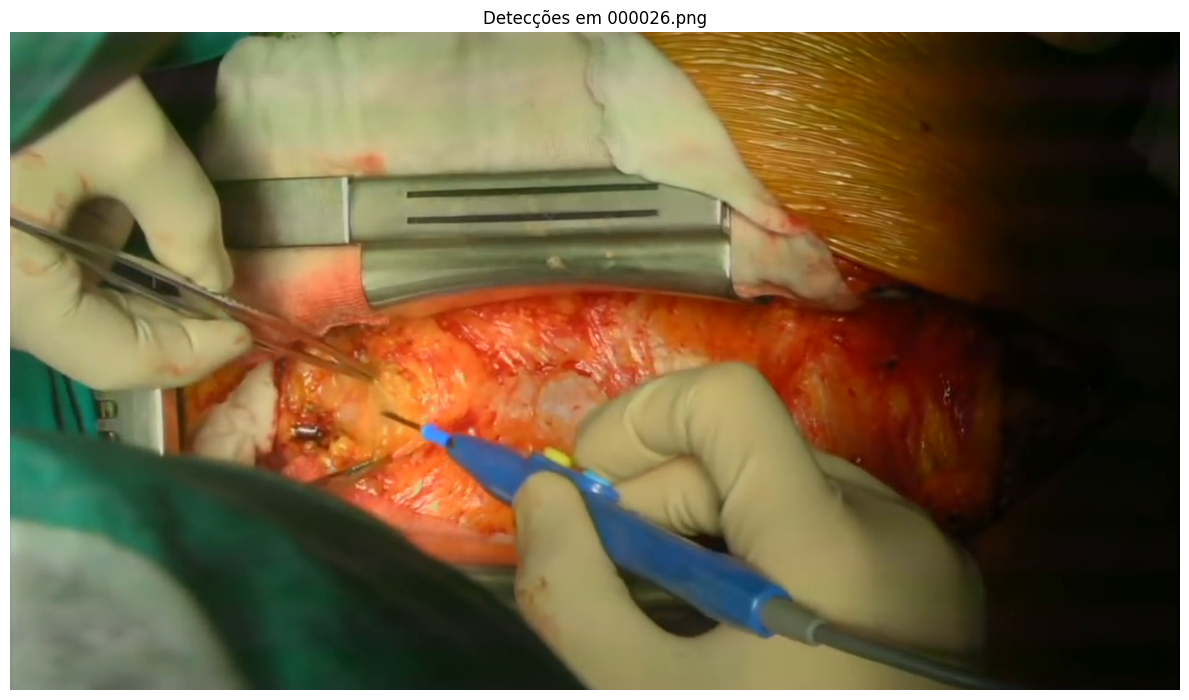

In [25]:
%matplotlib inline
import random
from pathlib import Path
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Configurar caminhos
photo_dir = Path("surgical_hands_release/images")

# Seleção aleatória em subpastas
subfolders = [f for f in photo_dir.iterdir() if f.is_dir()]
random_subfolder = random.choice(subfolders)
image_files = list(random_subfolder.glob("*.jpg")) + list(random_subfolder.glob("*.png"))
random_image_path = random.choice(image_files)

# Carregar modelo e imagem
model = YOLO("/mounts/grupo1/yolo_models/yoloTrackingWithHands3.pt")
frame = cv2.imread(str(random_image_path))

if frame is None:
    print("Erro ao carregar imagem")
else:
    # Fazer detecção
    results = model(frame)
    
    # Converter BGR para RGB e plotar
    result_img = results[0].plot()  # Já retorna imagem em BGR
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detecções em {random_image_path.name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
